### COSC102 Assignment 3 - Prepare Data
The purpose of this notebook is to prepare the data for the model training.
We will use the data from the IMU sensor to train a model to predict the activity of the user.



In [1]:

import csv
import matplotlib.pyplot as plt
import math
import numpy as np
import statistics


# Set some lists to store the IMU data.

time_track = []
ax_set = []
ay_set = []
az_set = []

gx_set = []
gy_set = []
gz_set = []

activity_set = []

def map_activity(activity_string):
    if activity_string == 'Standing':
        return 0
    elif activity_string == 'Walking':
        return 1
    elif activity_string == 'Jogging':
        return 2
    elif activity_string == 'Side_step':
        return 3
    elif activity_string == 'Running':
        return 4

In [2]:
# Read the IMU data from the csv file.
with open ('./datasets/a3_imu_data.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        time_track.append(float(row[0]));
        ax_set.append(float(row[1]))
        ay_set.append(float(row[2]))
        az_set.append(float(row[3]))
        gx_set.append(float(row[4]))
        gy_set.append(float(row[5]))
        gz_set.append(float(row[6]))

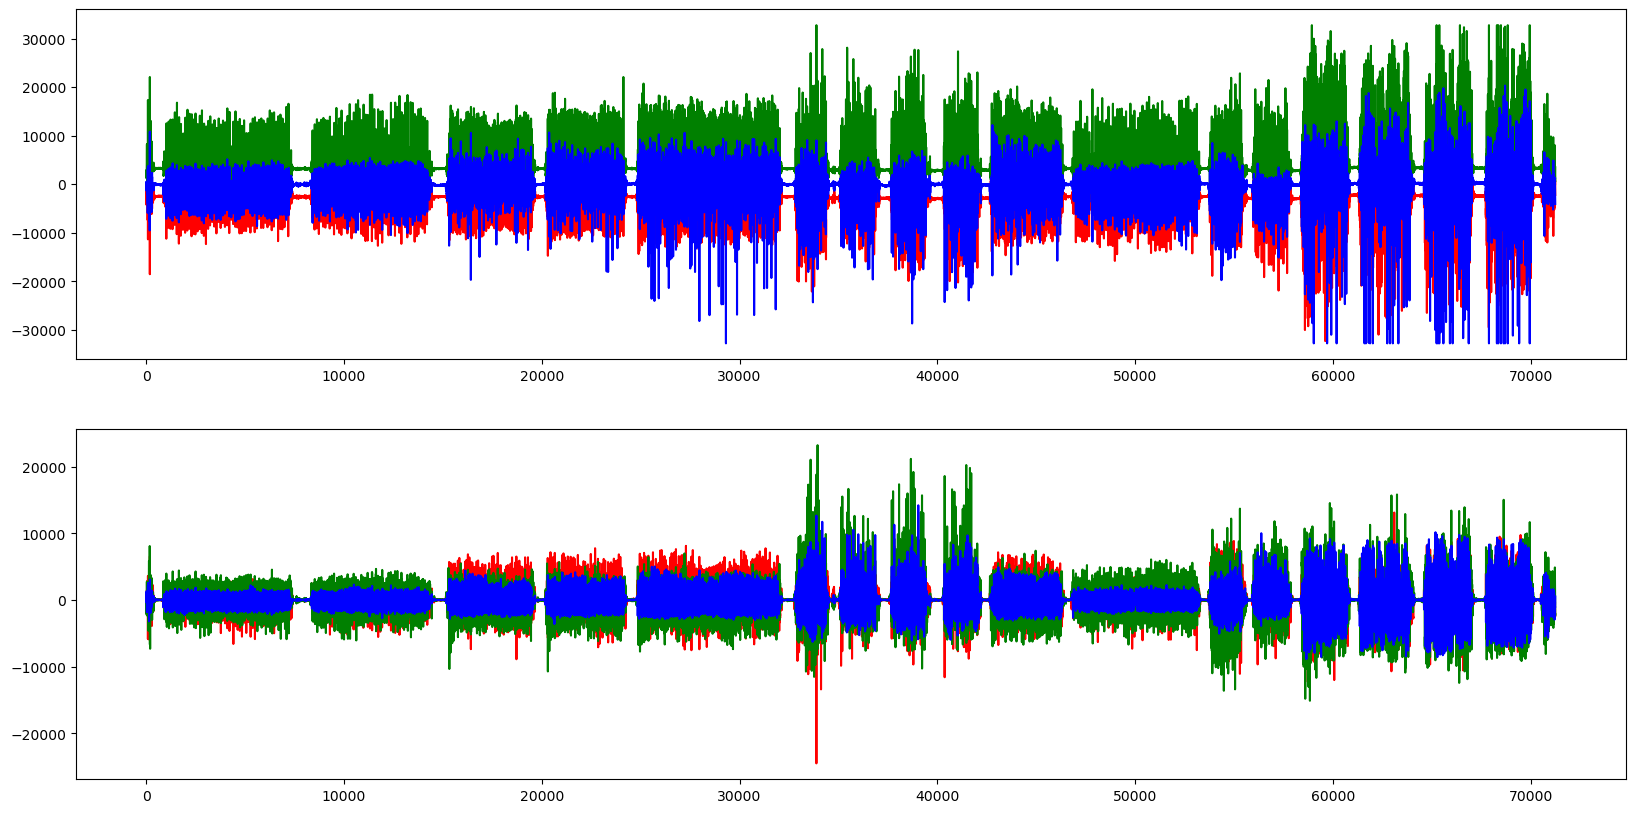

In [3]:
# Check the raw IMU data from the csv file.

fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(ax_set, color='r')
axs[0].plot(ay_set, color='g')
axs[0].plot(az_set, color='b')

axs[1].plot(gx_set, color='r')
axs[1].plot(gy_set, color='g')
axs[1].plot(gz_set, color='b')